In [27]:
# Initial imports
import panel as pn
pn.extension('plotly')

import datetime as dt
import hvplot.pandas
import json
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import seaborn as sns
import time

from pathlib import Path
from dotenv import load_dotenv

%matplotlib inline

## Part 1: Trading Volume by Fiat Currency

Coinbase provides trading volume data for 3 fiat currencies: the US Dollar (USD), the Euro (EUR), and the British Pound (GBP). The following visualizations compare the trading volumes between those fiat currencies.

In [28]:
# Coinbase API endpoints
coinbase_api_url = "https://api.pro.coinbase.com"
products_api_url = f"{coinbase_api_url}/products"
currencies_api_url = f"{coinbase_api_url}/currencies"

In [29]:
# Get currencies (fiat and crypto)
currencies_response = requests.get(currencies_api_url)
currencies = currencies_response.json()
currencies_df = pd.DataFrame(currencies)
currencies_df = pd.concat([currencies_df, pd.io.json.json_normalize(currencies_df["details"])], axis=1).drop(columns=["details"])
currencies_df.head()

,convertible_to,id,max_precision,message,min_size,name,status,crypto_address_link,crypto_transaction_link,display_name,group_types,max_withdrawal_amount,min_withdrawal_amount,network_confirmations,processing_time_seconds,push_payment_methods,sort_order,symbol,type
0,[],ALGO,0.000001,,1,Algorand,online,https://algoexplorer.io/address/{{address}},https://algoexplorer.io/tx/{{txId}},,[],1000000.0,0.1000,1,5,[crypto],93,A,crypto
1,[],DASH,0.00000001,,1,Dash,online,https://chain.so/address/DASH/{{address}},https://chain.so/tx/DASH/{{address}},,[],10000.0,0.0001,2,0,[crypto],47,,crypto
2,[],OXT,0.00000001,,1,Orchid,online,https://etherscan.io/token/0x4575f41308EC1483f...,https://etherscan.io/tx/0x{{txId}},,[],1000000.0,0.0100,35,0,[crypto],48,,crypto
3,[],ATOM,0.000001,,1,Cosmos,online,https://cosmos.bigdipper.live/account/{{address}},https://cosmos.bigdipper.live/transactions/{{t...,,[],100000.0,0.1000,0,5,[crypto],51,,crypto
4,[],KNC,0.00000001,,1,Kyber Network,online,https://etherscan.io/token/0xdd974d5c2e2928dea...,https://etherscan.io/tx/0x{{txId}},,[],2156253.0,0.0100,35,0,[crypto],120,Ξ,crypto


In [30]:
# Get Coinbase products (trading pairs)
products_response = requests.get(products_api_url)
products = products_response.json()
products_df = pd.DataFrame(products)
products_df.head()

,base_currency,base_increment,base_max_size,base_min_size,cancel_only,display_name,id,limit_only,margin_enabled,max_market_funds,min_market_funds,post_only,quote_currency,quote_increment,status,status_message,trading_disabled
0,ALGO,1.00000000,500000.00000000,1.00000000,False,ALGO/GBP,ALGO-GBP,False,False,100000,10,False,GBP,0.00010000,online,,False
1,ALGO,1.00000000,500000.00000000,1.00000000,False,ALGO/EUR,ALGO-EUR,False,False,100000,10,False,EUR,0.00010000,online,,False
2,ETH,0.00000001,1600.00000000,0.01000000,False,ETH/EUR,ETH-EUR,False,False,400000,10,False,EUR,0.01000000,online,,False
3,ETH,0.00010000,700.00000000,0.01000000,False,ETH/DAI,ETH-DAI,False,False,100000,10,False,DAI,0.01000000,online,,False
4,COMP,0.00100000,1700.00000000,0.01000000,False,COMP/BTC,COMP-BTC,False,False,10,0.0001,False,BTC,0.00000100,online,,False


In [31]:
def get_date_list(start_date, end_date):
    """
    Get the list of dates in 300-day incremenets.
    """
    delta_days = (end_date - start_date).days
    iterations = math.floor(delta_days / 300) + 1
    date_list = [start_date + dt.timedelta(days=x*300) for x in range(iterations)]
    return date_list

In [32]:
def get_candle_data(id, start_date):
    """
    Get historical data (daily) for a product between the start and end dates.
    """
    start_str = dt.datetime.strftime(start_date, "%Y-%m-%d")
    end_str = dt.datetime.strftime(start_date + dt.timedelta(days=300), "%Y-%m-%d")
    candles_url = f"{products_api_url}/{id}/candles?start={start_str}&end={end_str}&granularity=86400"
    candles_response = requests.get(candles_url)
    candles = candles_response.json()
    candles_df = pd.DataFrame(candles, columns=["time", "low", "high", "open", "close", "volume"])
    return candles_df

In [33]:
base_currency_id = "base_currency"
quote_currency_id = "quote_currency"

# Get list of fiat and cryptocurrencies and Coinbase products
crypto_currencies = currencies_df[currencies_df["type"] == "crypto"]["id"].tolist()
fiat_currencies = currencies_df[currencies_df["type"] == "fiat"]["id"].tolist()
fiat_products_df = products_df[products_df[quote_currency_id].isin(fiat_currencies)]

print(f"Crypto currencies: {crypto_currencies}")
print(f"Fiat currencies: {fiat_currencies}")

# Get list of dates to fetch data for in 300-day increments
today = dt.datetime.today()
base = dt.datetime.strptime("2009-01-01", "%Y-%m-%d")
date_list = get_date_list(base, today)

# Get data from Coinbase and append to dataframe
data_df = pd.DataFrame()
for idx, row in fiat_products_df.iterrows():
    product_id = row["id"]
    base_currency = row[base_currency_id]
    quote_currency = row[quote_currency_id]
    for start_date in date_list:
        df = get_candle_data(product_id, start_date)
        if not df.empty:
            df[base_currency_id] = base_currency
            df[quote_currency_id] = quote_currency
            data_df = data_df.append(df)

data_df.head()

Crypto currencies: ['ALGO', 'DASH', 'OXT', 'ATOM', 'KNC', 'XRP', 'REP', 'MKR', 'CGLD', 'COMP', 'NMR', 'OMG', 'BAND', 'UMA', 'XLM', 'EOS', 'ZRX', 'BAT', 'LOOM', 'UNI', 'YFI', 'LRC', 'CVC', 'DNT', 'MANA', 'GNT', 'REN', 'LINK', 'BTC', 'BAL', 'LTC', 'ETH', 'BCH', 'ETC', 'USDC', 'ZEC', 'XTZ', 'DAI', 'WBTC', 'NU', 'FIL', 'AAVE', 'SNX', 'BNT', 'GRT']
Fiat currencies: ['EUR', 'GBP', 'USD']


,time,low,high,open,close,volume,base_currency,quote_currency
0,1611360000,0.3668,0.4179,0.3725,0.4075,1196784.0,ALGO,GBP
1,1611273600,0.3132,0.3957,0.3363,0.3713,1684206.0,ALGO,GBP
2,1611187200,0.3288,0.4022,0.4008,0.3359,1547867.0,ALGO,GBP
3,1611100800,0.3562,0.4028,0.3837,0.4028,1423223.0,ALGO,GBP
4,1611014400,0.3775,0.4215,0.4163,0.3832,1710236.0,ALGO,GBP


In [34]:
# convert epoch time to date
data_df = data_df.drop_duplicates()
data_df["date"] = pd.to_datetime(data_df["time"], unit="s")
data_df = data_df.drop(columns=["time"])

In [35]:
# Get daily change in trading volume
fiat_volume_data_df = pd.concat([data_df[data_df[quote_currency_id] == fiat].groupby(["date"])["volume"].sum() for fiat in fiat_currencies], axis=1)
fiat_volume_data_df.columns = fiat_currencies
fiat_volume_pct_df = fiat_volume_data_df.pct_change()

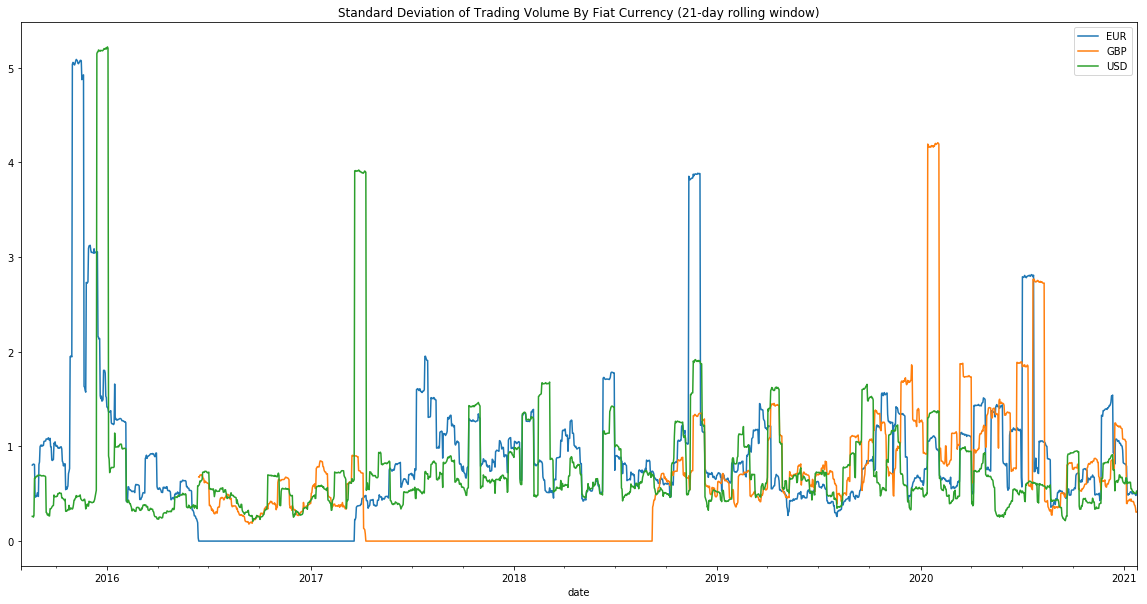

In [36]:
# calculate standard deviation
volume_std = fiat_volume_pct_df.std()

# Calculate rolling standard deviation
rolling_volume_std = fiat_volume_pct_df.rolling(window=21).std()

# Plot rolling standard deviation
ax = rolling_volume_std.plot(figsize=(20,10), title="Standard Deviation of Trading Volume By Fiat Currency (21-day rolling window)")
# ax.figure.savefig("trading_volume_std.png", bbox_inches="tight")

In [38]:
# visualize volume by fiat currency
fiat_volume_df = data_df[["date", quote_currency_id, "volume"]].groupby(["date", quote_currency_id]).sum()
fiat_volume_df.hvplot.line(x="date", y="volume", by=quote_currency_id, title="Trading Volume by Fiat Currency", height=500, width=1000)

:NdOverlay   [quote_currency]
   :Curve   [date]   (volume)

In [39]:
# visualize the number of unique traded cryptocurrencies for each fiat currency
crypto_count_df = data_df.groupby(["date", quote_currency_id])[base_currency_id].nunique()
crypto_count_df.hvplot.line(x="date", y=base_currency_id, by=quote_currency_id, title="Count of Unique Cryptocurrencies", height=300, width=1000)

:NdOverlay   [quote_currency]
   :Curve   [date]   (base_currency)

In [40]:
# visualize USD volume by base currency
usd_volume_df = data_df[data_df.quote_currency == "USD"].groupby(["date", base_currency_id])["volume"].sum()
usd_volume_df.hvplot.line(x="date", y="volume", by=base_currency_id, title="USD: Trading Volume of Each Cryptocurrency", height=500, width=1000)

:NdOverlay   [base_currency]
   :Curve   [date]   (volume)

In [41]:
# visualize GBP volume by base currency
gbp_volume_df = data_df[data_df.quote_currency == "GBP"].groupby(["date", base_currency_id])["volume"].sum()
gbp_volume_df.hvplot.line(x="date", y="volume", by=base_currency_id, title="GBP: Trading Volume of Each Cryptocurrency", height=500, width=1000)

:NdOverlay   [base_currency]
   :Curve   [date]   (volume)

In [42]:
# visualize GBP volume by base currency
eur_volume_df = data_df[data_df.quote_currency == "EUR"].groupby(["date", base_currency_id])["volume"].sum()
eur_volume_df.hvplot.line(x="date", y="volume", by=base_currency_id, title="EUR: Trading Volume of Each Cryptocurrency", height=500, width=1000)

:NdOverlay   [base_currency]
   :Curve   [date]   (volume)